# Ensemble comparison

This notebook sevres to compare the 2 ensmble classification approaches: splitting into different folds as per usual for cross val;idation and creating a vote based ensemble classifier and creating an ensemble by resampling the data. Ultimately we will create a super-ensemble from both sets of classifiers.

In [1]:
import os
import sys
import pathlib
import functools
import itertools
import datetime
import random

In [2]:
import pandas
import numpy

In [3]:
import matplotlib
import matplotlib.pyplot
import warnings
warnings.filterwarnings('ignore')

In [4]:
font = {'family' : 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.pyplot.style.use('ggplot')

In [5]:
import ipywidgets
import time

In [6]:
import sklearn
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.tree
import sklearn.metrics

In [7]:
root_repo_dir = pathlib.Path().absolute().parent
sys.path = [os.path.join(root_repo_dir)] + sys.path

In [8]:
import xbt.dataset
from xbt.dataset import XbtDataset, UNKNOWN_STR, cat_output_formatter, check_value_found
from xbt.imeta import imeta_classification, XBT_MAX_DEPTH

In [9]:
# Set up some site specific parameters for the notebook
try:
    environment = os.environ['XBT_ENV_NAME']
except KeyError:
    environment = 'pangeo'

In [10]:
root_data_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/',
    'pangeo': '/data/misc/xbt-data/',
}
env_date_ranges = {
    'MO_scitools': (1966,2015),
    'pangeo': (1966,2015)
}

In [11]:
# Set up some dataset specific parameters
root_data_dir = root_data_dirs[environment]
year_range = env_date_ranges[environment]

In [12]:
metrics_avg = 'weighted'
cv_metric_names = [f'recall_{metrics_avg}', f'precision_{metrics_avg}', f'f1_{metrics_avg}']
input_feature_names = ['country','max_depth', 'year', 'lat', 'lon']
target_feature_name = 'instrument'

In [14]:
splitter_features = ['year', 'instrument']
test_feature = 'cruise_number'
ensemble_test_fraction = 0.1
num_test_splits = 5
test_fraction = 1.0 / num_test_splits
num_train_splits = 5
train_fraction = 1.0 - (1.0 / num_train_splits)
test_fold_name = 'test_fold'

In [15]:
input_dir_name = 'csv_with_imeta'
exp_out_dir_name = 'experiment_outputs'

In [16]:
experiment_name = 'nb_single_decisionTree_country'
classifier_class = sklearn.tree.DecisionTreeClassifier
classifier_name = 'decision_tree'
suffix='countryAndLatLon'

In [17]:
classifier_opts = {'max_depth': 20,
                   'min_samples_leaf': 1,
                   'criterion': 'gini'
                  }

In [18]:
xbt_input_dir = os.path.join(root_data_dir, input_dir_name)
xbt_output_dir = os.path.join(root_data_dir, exp_out_dir_name, experiment_name)

In [19]:
# create the output for this experiment if it doesn't exist
if not os.path.isdir(xbt_output_dir):
    os.makedirs(xbt_output_dir)
print(f'outputting to {xbt_output_dir}')

outputting to /data/users/shaddad/xbt-data/experiment_outputs/nb_single_decisionTree_country


In [20]:
output_fname_template = 'xbt_output_{exp_name}_{subset}.csv'
result_fname_template = 'xbt_metrics_{classifier}_{suffix}.csv'

In [21]:
%%time
xbt_full_dataset = XbtDataset(xbt_input_dir, year_range)

CPU times: user 56.1 s, sys: 13.2 s, total: 1min 9s
Wall time: 1min 22s


## Data preparation

We are only testing on the labelled data, to be able to evluate performance. The XbtDataset class has filtered out some bad data including profiles with maximum depths less that 0.0 or greater than 2000.0. There were also some profiles with bad date entries, which have been excluded for now.

In [22]:
%%time
xbt_labelled = xbt_full_dataset.filter_obs({'labelled': 'labelled'})

CPU times: user 236 ms, sys: 33.9 ms, total: 270 ms
Wall time: 267 ms


In [23]:
_ = xbt_labelled.get_ml_dataset(return_data = False)

In [24]:
_ = xbt_labelled.filter_features(['instrument','model','manufacturer']).encode_target(return_data = False)

In [25]:
%%time
test_cruise_numbers = xbt_labelled.sample_feature_values('cruise_number', fraction=0.1)
test_var_name = 'test'
test_part_name = 'test_part'
test_whole_name = 'test_whole'
test_indices = list(itertools.chain.from_iterable([list(xbt_labelled.filter_obs({target_feature_name: selected_instrument}).xbt_df.sample(frac=0.1).index) 
for selected_instrument in xbt_labelled['instrument'].unique()]))

CPU times: user 1.68 s, sys: 6.88 ms, total: 1.69 s
Wall time: 1.68 s


In [33]:
# label test data based on whole cruises set aside
xbt_labelled.xbt_df[test_var_name] = xbt_labelled.xbt_df['cruise_number'].isin(test_cruise_numbers)
xbt_labelled.xbt_df[test_whole_name] = xbt_labelled.xbt_df['cruise_number'].isin(test_cruise_numbers)

In [ ]:
# label test data where part of the cruise is in the train/validation sets
xbt_labelled.xbt_df.loc[test_indices, test_var_name] = True
xbt_labelled.xbt_df[test_part_name] = False
xbt_labelled.xbt_df.loc[test_indices, test_part_name] = True


In [27]:
imeta_classes = xbt_labelled.xbt_df.apply(imeta_classification, axis=1)
imeta_model = imeta_classes.apply(lambda t1: t1[0])
imeta_manufacturer = imeta_classes.apply(lambda t1: t1[1])

In [28]:
imeta_feature_name = f'{target_feature_name}_imeta'

In [29]:
imeta_instrument = imeta_classes.apply(lambda t1: f'XBT: {t1[0]} ({t1[1]})') 
xbt_labelled.xbt_df[imeta_feature_name] = imeta_instrument
xbt_labelled._target_encoders[imeta_feature_name] = xbt_labelled._target_encoders[target_feature_name]
xbt_labelled._feature_encoders[imeta_feature_name] = xbt_labelled._feature_encoders[target_feature_name]

In [30]:
%%time
xbt_test = xbt_labelled.filter_obs({test_var_name: True})
xbt_working = xbt_labelled.filter_obs({test_var_name: False})

CPU times: user 138 ms, sys: 10.1 ms, total: 148 ms
Wall time: 146 ms


get separate sets of 2 types of validation data.
* data from cruises where the whole cruise is in the validation data 
* data where some of the profiles are in the training data

In [34]:
xbt_test_whole = xbt_labelled.filter_obs({test_whole_name: True})
xbt_test_part = xbt_labelled.filter_obs({test_part_name: True})

In [35]:
X_test_all = xbt_test.filter_features(input_feature_names).get_ml_dataset()[0]
y_instr_test_all = xbt_test.filter_features([target_feature_name]).get_ml_dataset()[0]

## Resampling the data and training classifiers

In [36]:
num_resamples_per_class = 50000

In [37]:
instrument_sample_list = [instrument1 
                          for instrument1, count1 in zip(
                              xbt_labelled.xbt_df[target_feature_name].value_counts().index, 
                              xbt_labelled.xbt_df[target_feature_name].value_counts()) 
                          if count1 > 100] 

In [38]:
def get_resampled(instrument_list, xbt_subset1, resample_index, random_state):
    resampled_profiles_list = [xbt_subset1.filter_obs({target_feature_name: ins1}).xbt_df.sample(
        num_resamples_per_class, 
        replace=True,
        random_state=random_state,
    ) 
         for ins1 in instrument_list]
    resampled_training_indices = list(set(itertools.chain.from_iterable([list(rp1.index) for rp1 in resampled_profiles_list])))
    if resample_index is None:
        resample_index = 0
    resample_feature_name = f'resample_train_{resample_index}'
    xbt_subset1.xbt_df[resample_feature_name] = xbt_working.xbt_df.index.isin(resampled_training_indices)
    resampled_df = pandas.concat(
        resampled_profiles_list,
        ignore_index=True,
    )
    xbt_resampled_train_all = XbtDataset(xbt_input_dir, year_range, df=resampled_df)
    xbt_resampled_train_all._feature_encoders = xbt_labelled._feature_encoders
    xbt_resampled_train_all._arget_encoders = xbt_labelled._target_encoders
    xbt_resampled_validation_all = xbt_working.filter_obs({resample_feature_name: False})
    return (xbt_resampled_train_all, xbt_resampled_validation_all)

In [39]:
%%time
clf_dict_resampled = {}
for resample_index in range(1,6):
    xbt_resampled_train_all, xbt_resampled_validation_all = get_resampled(
        instrument_sample_list, 
        xbt_working, 
        resample_index=resample_index,
        random_state=int((datetime.datetime.now().timestamp()*1e5) % 1e5),
    )
    clf1 = classifier_class(**classifier_opts)
    clf1.fit(xbt_resampled_train_all.filter_features(input_feature_names).get_ml_dataset()[0],
             xbt_resampled_train_all.filter_features([target_feature_name]).get_ml_dataset()[0],
            ) 
    clf_dict_resampled[resample_index] = clf1

CPU times: user 1min 8s, sys: 2.3 s, total: 1min 11s
Wall time: 1min 11s


### Calculating the ensemble outputs

In [40]:
d1 = {
    f'{target_feature_name}_res_{ix1}': 
    xbt_test._feature_encoders[target_feature_name].inverse_transform(
        clf1.predict(xbt_test.filter_features(input_feature_names).get_ml_dataset()[0]))
    for ix1, clf1 in clf_dict_resampled.items()
}
d1['id'] = xbt_test['id']
instr_predictions_test = pandas.DataFrame(d1)

In [41]:
ens_res_features = [f'{target_feature_name}_res_{ix1}' for ix1, clf1 in clf_dict_resampled.items()]

In [42]:
xbt_test.xbt_df = pandas.DataFrame.merge(xbt_test.xbt_df, instr_predictions_test, on='id')

In [43]:
%%time
calc_disagreements = lambda x: len(set(x))
vote_counts_df = pandas.DataFrame.from_records( 
    {year1: 
     dict(xbt_test.filter_obs({'year': year1}).filter_features(ens_res_features).xbt_df.apply(
         calc_disagreements, axis='columns').value_counts()) 
     for year1 in range(*year_range)},
).transpose().fillna(0.0)
vote_counts_df['year'] = vote_counts_df.index


CPU times: user 2.25 s, sys: 32.9 ms, total: 2.28 s
Wall time: 2.28 s


In [44]:
probs_test_instrument = functools.reduce(
    lambda x,y: x+y, 
    [xbt_labelled._target_encoders[target_feature_name].transform(instr_predictions_test[[pred1]])
     for pred1 in instr_predictions_test.columns 
     if 'res' in pred1]) / len(instr_predictions_test.columns)
probs_test_instrument_df = pandas.DataFrame({col_name: probs_test_instrument[:,col_ix1]
for col_ix1, col_name in enumerate(xbt_labelled._target_encoders[target_feature_name].categories_[0])})

In [45]:
max_prob_resample_ensemble = probs_test_instrument_df.idxmax(axis='columns')

# Cross-validation based ensemble on imbalanced data

In [46]:
%%time
xbt_working.generate_folds_by_feature('cruise_number', num_test_splits, test_fold_name)

CPU times: user 30.3 s, sys: 24.8 ms, total: 30.4 s
Wall time: 30.4 s


In [47]:
cruise_numbers = list(xbt_working['cruise_number'].unique())

In [48]:
X_labelled = xbt_working.filter_features(input_feature_names).get_ml_dataset()[0]
y_labelled = xbt_working.filter_features([target_feature_name]).get_ml_dataset()[0]


In [49]:
group_cv1 = sklearn.model_selection.KFold(n_splits=num_test_splits,
                                         shuffle=True,
                                         random_state=random.randint(1,2**20))
clf_dt1 = classifier_class(**classifier_opts)

In [50]:
%%time
scores = sklearn.model_selection.cross_validate(
    clf_dt1,
    X_labelled, y_labelled, 
    groups=xbt_working[test_fold_name], 
    cv=group_cv1,
    return_estimator=True,
    return_train_score=True,
    scoring=cv_metric_names,
    n_jobs=-1,
)

CPU times: user 266 ms, sys: 552 ms, total: 817 ms
Wall time: 21.3 s


### Calculating ensemble outputs

In [51]:
d1 = {
    f'{target_feature_name}_res_cv_{ix1}': 
    xbt_test._feature_encoders[target_feature_name].inverse_transform(
        clf1.predict(xbt_test.filter_features(input_feature_names).get_ml_dataset()[0]))
    for ix1, clf1 in enumerate(scores['estimator'])
}
d1['id'] = xbt_test['id']
instr_predictions_test_cv = pandas.DataFrame(d1)

In [52]:
ens_res_features_cv = [f'{target_feature_name}_res_cv_{ix1}' for ix1, clf1 in enumerate(scores['estimator'])]

In [53]:
xbt_test.xbt_df = pandas.DataFrame.merge(xbt_test.xbt_df, instr_predictions_test_cv, on='id')

In [54]:
%%time
vote_counts_cv_df = pandas.DataFrame.from_records( 
    {year1: 
     dict(xbt_test.filter_obs({'year': year1}).filter_features(ens_res_features_cv).xbt_df.apply(
         calc_disagreements, axis='columns').value_counts()) for year1 in range(*year_range)},
).transpose().fillna(0.0)
vote_counts_cv_df['year'] = vote_counts_cv_df.index

CPU times: user 2.6 s, sys: 42.9 ms, total: 2.64 s
Wall time: 2.64 s


In [55]:
probs_test_instrument_cv = functools.reduce(
    lambda x,y: x+y, 
    [xbt_labelled._target_encoders[target_feature_name].transform(instr_predictions_test_cv[[pred1]])
     for pred1 in instr_predictions_test_cv.columns 
     if 'res_cv' in pred1]) / len(instr_predictions_test_cv.columns)
probs_test_instrument_cv_df = pandas.DataFrame({col_name: probs_test_instrument_cv[:,col_ix1]
for col_ix1, col_name in enumerate(xbt_labelled._target_encoders[target_feature_name].categories_[0])})

In [56]:
max_prob_cv_ensemble = probs_test_instrument_cv_df.idxmax(axis='columns')

In [57]:
clf_dict_cv = {ix1: clf1 for ix1, clf1 in enumerate(scores['estimator'])}

## Calculate metrics

In [58]:
def calc_metric_subset(xbt_subset, clf1, filter_dict, inputs, target_feature, metric_func, metric_args_dict):
    if filter_dict:
        xbt_selected = xbt_subset.filter_obs(filter_dict)
    else:
        xbt_selected = xbt_subset
    if xbt_selected.shape[0] == 0:
        return 0.0
    metrics_result = metric_func(
        clf1.predict(xbt_selected.filter_features(inputs).get_ml_dataset()[0]),
        xbt_selected.filter_features([target_feature]).get_ml_dataset()[0],
        **metric_args_dict)
    return metrics_result                       

In [60]:
instrument_list = list(xbt_labelled._feature_encoders[target_feature_name].classes_)

In [61]:
do_avg_args_dict = {'labels':list(range(0,len(instrument_list))), 
                    'average':'weighted'}
metrics_defs_dict = {
    'recall': {'metric_func': sklearn.metrics.recall_score, 'metric_args_dict': do_avg_args_dict},
    'precision': {'metric_func': sklearn.metrics.precision_score, 'metric_args_dict': do_avg_args_dict},
    'accuracy': {'metric_func': sklearn.metrics.accuracy_score, 'metric_args_dict': {}},
    'f1': {'metric_func': sklearn.metrics.f1_score, 'metric_args_dict': do_avg_args_dict},
    'balanced_accuracy': {'metric_func': sklearn.metrics.balanced_accuracy_score, 'metric_args_dict': {}},    
}


In [63]:
metrics_imeta_all = { f'{metric_name}_instr_ens' :
    metric1['metric_func'](
        xbt_test.filter_features([f'{target_feature_name}_imeta']).get_ml_dataset()[0],
        xbt_test.filter_features([target_feature_name]).get_ml_dataset()[0],
        **metric1['metric_args_dict']
    )
    for metric_name,metric1 in metrics_defs_dict.items()    
}
metrics_imeta_all['classifier'] = 'imeta'

In [64]:
%%time
metrics_test_resampled_ens = pandas.DataFrame({ f'{metric_name}_instr_ens': [
    calc_metric_subset(xbt_test, 
                       clf1, 
                       None,
                       input_feature_names,
                       target_feature_name,
                       **metric1
                      ) for res_ix1, clf1 in clf_dict_resampled.items()]
 for metric_name,metric1 in metrics_defs_dict.items() 
})
metrics_test_resampled_ens['classifier'] = [
    f'resampled_{res_ix1}' for res_ix1, clf1 in clf_dict_resampled.items()]

CPU times: user 7.24 s, sys: 1.15 s, total: 8.39 s
Wall time: 8.39 s


In [65]:
%%time
metrics_test_cv_ens = pandas.DataFrame({ f'{metric_name}_instr_ens': [
    calc_metric_subset(xbt_test, 
                       clf1, 
                       None,
                       input_feature_names,
                       target_feature_name,
                       **metric1
                      ) for res_ix1, clf1 in clf_dict_cv.items()]
 for metric_name,metric1 in metrics_defs_dict.items() 
})
metrics_test_cv_ens['classifier'] = [
    f'cv_{res_ix1}' for res_ix1, clf1 in clf_dict_cv.items()]

CPU times: user 7.23 s, sys: 1.33 s, total: 8.56 s
Wall time: 8.56 s


In [66]:
metrics_all_classifiers = pandas.concat([
    metrics_test_resampled_ens,
    metrics_test_cv_ens,
    pandas.DataFrame.from_records([metrics_imeta_all]),
])
metrics_all_classifiers 

,recall_instr_ens,precision_instr_ens,accuracy_instr_ens,f1_instr_ens,balanced_accuracy_instr_ens,classifier
0,0.906018,0.903344,0.906018,0.900307,0.572243,resampled_1
1,0.903450,0.901197,0.903450,0.897879,0.576062,resampled_2
2,0.905175,0.902849,0.905175,0.900030,0.567952,resampled_3
3,0.907526,0.905806,0.907526,0.902091,0.557007,resampled_4
4,0.907049,0.904820,0.907049,0.901858,0.564130,resampled_5
0,0.939675,0.942081,0.939675,0.940359,0.748968,cv_0
1,0.939636,0.941530,0.939636,0.940216,0.727702,cv_1
2,0.938706,0.940931,0.938706,0.939278,0.712468,cv_2
3,0.940426,0.942657,0.940426,0.941106,0.718732,cv_3
4,0.939622,0.941989,0.939622,0.940364,0.737669,cv_4


In [67]:
%%time
metrics_raw_dict = { f'{metric_name}_instr_{res_ix1}': [calc_metric_subset(xbt_test, 
                   clf1, 
                   {target_feature_name: fn1},
                   input_feature_names,
                    target_feature_name,
                   **metric1
                  ) for  fn1 in instrument_list]
 for metric_name,metric1 in metrics_defs_dict.items() 
 for res_ix1, clf1 in clf_dict_resampled.items()
}
metrics_raw_dict['num_profiles'] = [xbt_labelled.filter_obs({target_feature_name: fn1}).shape[0] 
                                    for  fn1 in instrument_list]
metrics_raw_dict[target_feature_name] = [fn1 for  fn1 in instrument_list]

metrics_per_class_resampled_df = pandas.DataFrame(metrics_raw_dict)
metrics_per_class_resampled_df = metrics_per_class_resampled_df.sort_values('num_profiles', ascending=False)

for metric_name in metrics_defs_dict.keys(): 
    metrics_per_class_resampled_df[f'{metric_name}_instr_avg'] = metrics_per_class_resampled_df[[c1 for c1 in metrics_per_class_resampled_df.columns if metric_name in c1]].mean(axis='columns')

CPU times: user 44.5 s, sys: 234 ms, total: 44.7 s
Wall time: 44.7 s


In [68]:
%%time
metrics_raw_cv_dict = { f'{metric_name}_instr_{res_ix1}': [calc_metric_subset(xbt_test, 
                   clf1, 
                   {target_feature_name: fn1},
                   input_feature_names,
                    target_feature_name,
                   **metric1
                  ) for  fn1 in instrument_list]
 for metric_name,metric1 in metrics_defs_dict.items() 
 for res_ix1, clf1 in clf_dict_cv.items()
}
metrics_raw_cv_dict['num_profiles'] = [xbt_labelled.filter_obs({target_feature_name: fn1}).shape[0] 
                                       for fn1 in instrument_list]
metrics_raw_cv_dict[target_feature_name] = [fn1 for  fn1 in instrument_list]

metrics_per_class_cv_df = pandas.DataFrame(metrics_raw_cv_dict)
metrics_per_class_cv_df = metrics_per_class_cv_df.sort_values('num_profiles', ascending=False)
for metric_name in metrics_defs_dict.keys(): 
    metrics_per_class_cv_df[f'{metric_name}_instr_avg'] = metrics_per_class_cv_df[[c1 for c1 in metrics_per_class_cv_df.columns if metric_name in c1]].mean(axis='columns')

CPU times: user 45.3 s, sys: 234 ms, total: 45.5 s
Wall time: 45.5 s


In [69]:
%%time
metrics_annual_raw_dict = { f'{metric_name}_instr_{res_ix1}': [calc_metric_subset(xbt_test, 
                   clf1, 
                   {'year': year1},
                   input_feature_names,
                   target_feature_name,
                   **metric1
                  ) for  year1 in range(*year_range)]
 for metric_name,metric1 in metrics_defs_dict.items() 
 for res_ix1, clf1 in clf_dict_resampled.items()
}
metrics_annual_raw_dict['num_profiles'] = [xbt_labelled.filter_obs({'year': year1}).shape[0] 
                                           for year1 in range(*year_range)]
metrics_annual_raw_dict['year'] = [year1 for  year1 in range(*year_range)]

metrics_annual_resampled_df = pandas.DataFrame(metrics_annual_raw_dict)
for metric_name in metrics_defs_dict.keys(): 
    metrics_annual_resampled_df[f'{metric_name}_instr_avg'] = metrics_annual_resampled_df[[c1 for c1 in metrics_annual_resampled_df.columns if metric_name in c1]].mean(axis='columns')

CPU times: user 1min 15s, sys: 670 ms, total: 1min 16s
Wall time: 1min 16s


In [70]:
%%time
metrics_annual_raw_dict = { f'{metric_name}_instr_{res_ix1}': [calc_metric_subset(xbt_test, 
                   clf1, 
                   {'year': year1},
                   input_feature_names,
                   target_feature_name,
                   **metric1
                  ) for  year1 in range(*year_range)]
 for metric_name,metric1 in metrics_defs_dict.items() 
 for res_ix1, clf1 in clf_dict_cv.items()
}
metrics_annual_raw_dict['num_profiles'] = [xbt_labelled.filter_obs({'year': year1}).shape[0] for year1 in range(*year_range)]
metrics_annual_raw_dict['year'] = [year1 for  year1 in range(*year_range)]

metrics_annual_cv_df = pandas.DataFrame(metrics_annual_raw_dict)
for metric_name in metrics_defs_dict.keys(): 
    metrics_annual_cv_df[f'{metric_name}_instr_avg'] = metrics_annual_cv_df[[c1 for c1 in metrics_annual_cv_df.columns if metric_name in c1]].mean(axis='columns')

CPU times: user 1min 14s, sys: 745 ms, total: 1min 14s
Wall time: 1min 14s


In [114]:
xbt_test.filter_features([target_feature_name]).get_ml_dataset()[0]

array([[9],
       [9],
       [9],
       ...,
       [2],
       [2],
       [2]])

In [142]:
recall_comparison_dict = []

In [143]:
recall_comparison_dict += [{'name': 'Recall max prob meta-ensemble',
                            'recall_instr': 
                            metrics_defs_dict['recall']['metric_func'](
                                    xbt_labelled._feature_encoders[target_feature_name].transform(max_prob_super_ensemble),
                                xbt_test.filter_features([target_feature_name]).get_ml_dataset()[0],
                                **metrics_defs_dict['recall']['metric_args_dict']
                            )}]

In [144]:
recall_comparison_dict += [{'name': 'Recall max prob resampled',
                            'recall_instr': 
                            metrics_defs_dict['recall']['metric_func'](
                                xbt_labelled._feature_encoders[target_feature_name].transform(max_prob_resample_ensemble),
                                xbt_test.filter_features([target_feature_name]).get_ml_dataset()[0],
                                **metrics_defs_dict['recall']['metric_args_dict']
                            )}]

In [145]:
recall_comparison_dict += [{'name': 'Recall max prob k-fold',
                            'recall_instr': 
                            metrics_defs_dict['recall']['metric_func'](
                                xbt_labelled._feature_encoders[target_feature_name].transform(max_prob_cv_ensemble),
                                xbt_test.filter_features([target_feature_name]).get_ml_dataset()[0],
                                **metrics_defs_dict['recall']['metric_args_dict']
                            )}]

In [146]:
recall_comparison_dict += [{'name': 'Recall iMeta',
                            'recall_instr': 
                            metrics_defs_dict['recall']['metric_func'](
                                xbt_test.filter_features(['instrument_imeta']).get_ml_dataset()[0],
                                xbt_test.filter_features([target_feature_name]).get_ml_dataset()[0],
                                **metrics_defs_dict['recall']['metric_args_dict']
                            )}]


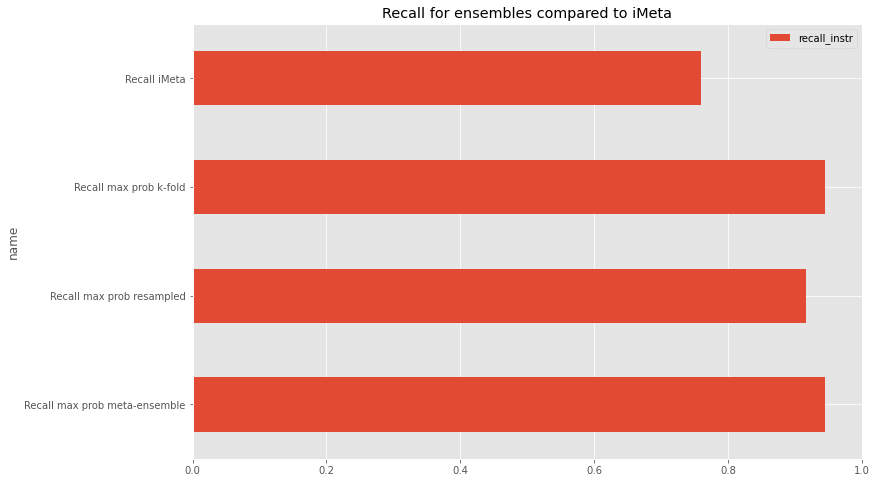

In [150]:
fig1 = matplotlib.pyplot.figure('recall_comparison',figsize=(12,8))
ax1 = fig1.add_subplot(1,1,1, title='Recall for ensembles compared to iMeta')
pandas.DataFrame(recall_comparison_dict).plot.barh(x='name', 
                                                   y='recall_instr',
                                                   xlim=(0.0,1.0),
                                                   ax=ax1
                                                  )
fig1.savefig('/data/users/shaddad/xbt-data/plots/recall_maxProb_ensembles_imeta.png',
            bbox_inches='tight')

In [102]:
xbt_labelled.xbt_df.columns

Index(['country', 'lat', 'lon', 'date', 'year', 'month', 'day', 'institute',
       'platform', 'cruise_number', 'instrument', 'model', 'manufacturer',
       'max_depth', 'imeta_applied', 'id', 'test', 'test_part',
       'instrument_imeta', 'test_whole'],
      dtype='object')

## Plotting metrics

In [71]:
metrics_all_classifiers

,recall_instr_ens,precision_instr_ens,accuracy_instr_ens,f1_instr_ens,balanced_accuracy_instr_ens,classifier
0,0.906018,0.903344,0.906018,0.900307,0.572243,resampled_1
1,0.903450,0.901197,0.903450,0.897879,0.576062,resampled_2
2,0.905175,0.902849,0.905175,0.900030,0.567952,resampled_3
3,0.907526,0.905806,0.907526,0.902091,0.557007,resampled_4
4,0.907049,0.904820,0.907049,0.901858,0.564130,resampled_5
0,0.939675,0.942081,0.939675,0.940359,0.748968,cv_0
1,0.939636,0.941530,0.939636,0.940216,0.727702,cv_1
2,0.938706,0.940931,0.938706,0.939278,0.712468,cv_2
3,0.940426,0.942657,0.940426,0.941106,0.718732,cv_3
4,0.939622,0.941989,0.939622,0.940364,0.737669,cv_4


<AxesSubplot:title={'center':'F1 for all data in splits'}, ylabel='classifier'>

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


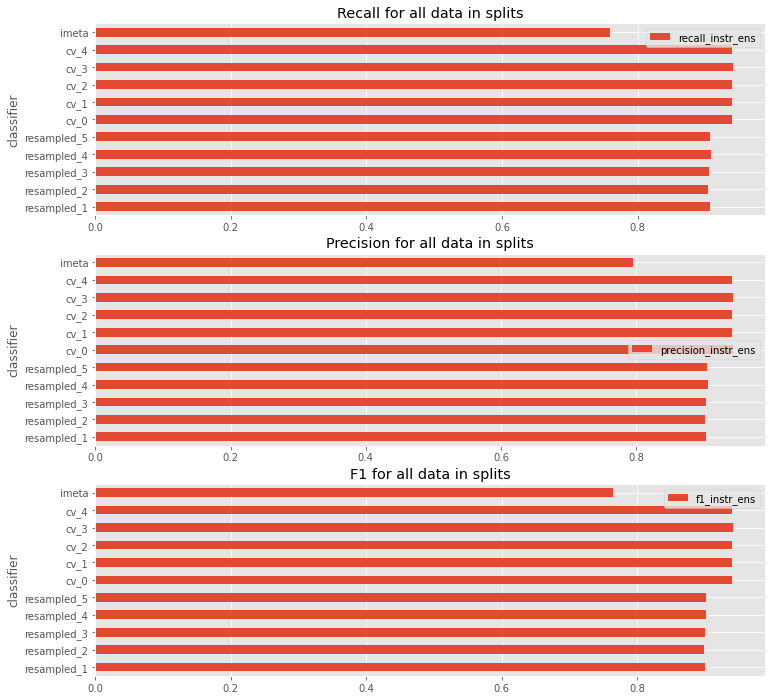

In [72]:
fig1 = matplotlib.pyplot.figure('imbalanced_metrics_all', figsize=(12,12))
ax1 = fig1.add_subplot(3,1,1,title='Recall for all data in splits')
metrics_all_classifiers.plot.barh(x='classifier', y='recall_instr_ens', ax=ax1)
ax1 = fig1.add_subplot(3,1,2,title='Precision for all data in splits')
metrics_all_classifiers.plot.barh(x='classifier', y='precision_instr_ens', ax=ax1)
ax1 = fig1.add_subplot(3,1,3,title='F1 for all data in splits')
metrics_all_classifiers.plot.barh(x='classifier', y='f1_instr_ens', ax=ax1)

In [73]:
metrics_per_class_cv_df_plot = metrics_per_class_cv_df[[(xbt_test.filter_obs({target_feature_name: ins1}).shape[0] >10) for ins1 in metrics_per_class_cv_df['instrument']]]
metrics_per_class_resampled_df_plot = metrics_per_class_resampled_df[[(xbt_test.filter_obs({target_feature_name: ins1}).shape[0] >10) for ins1 in metrics_per_class_resampled_df['instrument']]]

In [74]:
metrics_per_class_cv_df[['recall_instr_avg', 'instrument', 'num_profiles']]

,recall_instr_avg,instrument,num_profiles
9,0.966931,XBT: T4 (SIPPICAN),453270
2,0.977217,XBT: DEEP BLUE (SIPPICAN),346505
15,0.885102,XBT: T7 (SIPPICAN),211057
6,0.870658,XBT: T10 (SIPPICAN),43894
16,0.869920,XBT: T7 (TSK - TSURUMI SEIKI Co.),20893
14,0.952337,XBT: T6 (TSK - TSURUMI SEIKI Co.),17139
11,0.737598,XBT: T5 (SIPPICAN),15900
13,0.704943,XBT: T6 (SIPPICAN),7820
10,0.958873,XBT: T4 (TSK - TSURUMI SEIKI Co.),7691
4,0.836464,XBT: FAST DEEP (SIPPICAN),5095


In [75]:
table_comparison_classes = pandas.DataFrame({'instrument': metrics_per_class_cv_df['instrument'], 
                  'recall_imbalanced': metrics_per_class_cv_df['recall_instr_avg'],
                  'recall_resampled': metrics_per_class_resampled_df['recall_instr_avg'],
                  'precision_imbalanced': metrics_per_class_cv_df['precision_instr_avg'],
                  'precision_resampled': metrics_per_class_resampled_df['precision_instr_avg'],
                   'support': metrics_per_class_resampled_df['num_profiles'],
                 })
table_comparison_classes.to_csv('/data/users/shaddad/xbt-data/plots/per_class_imablancesVsResampled.csv', index=False)

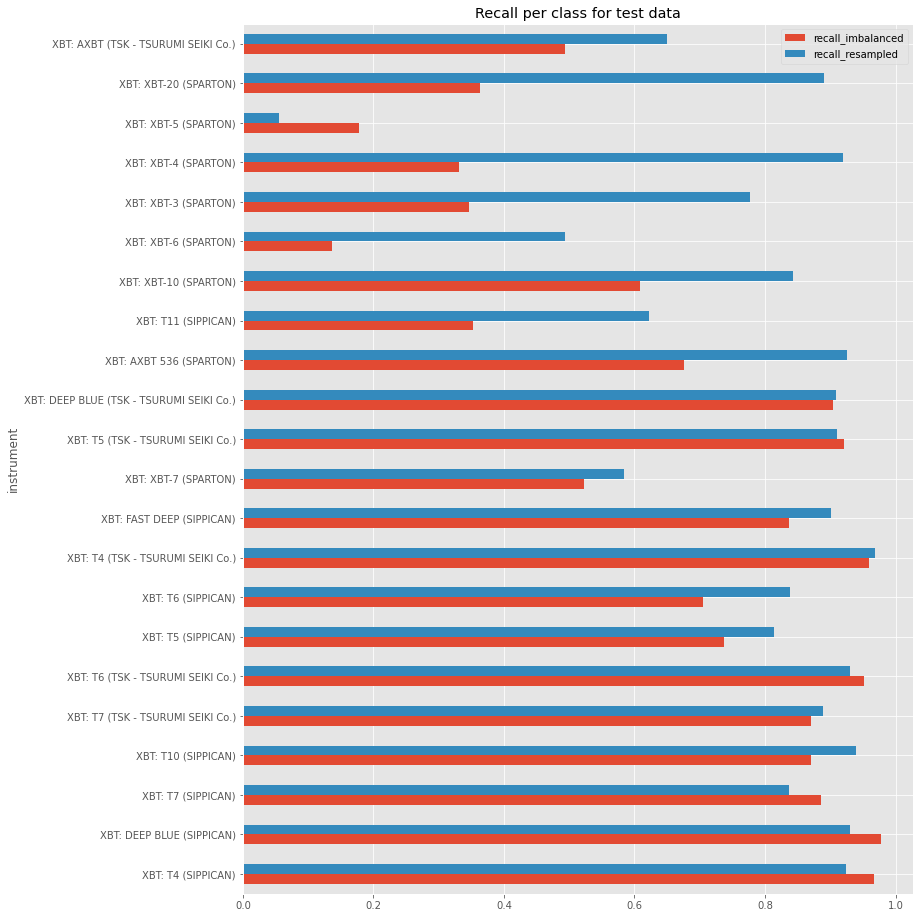

In [76]:
fig1 = matplotlib.pyplot.figure('recall_per_class_test', figsize=(12,16))
ax1 = fig1.add_subplot(1,1,1,title='Recall per class for test data')
_ = pandas.DataFrame({'instrument': metrics_per_class_resampled_df_plot['instrument'], 
                  'recall_imbalanced': metrics_per_class_cv_df_plot['recall_instr_avg'],
                  'recall_resampled': metrics_per_class_resampled_df_plot['recall_instr_avg'],
                 }).plot.barh(x='instrument', ax=ax1)
fig1.savefig('/data/users/shaddad/xbt-data/plots/recall_test_per_class_imbalancedClf.png', bbox_inches='tight')

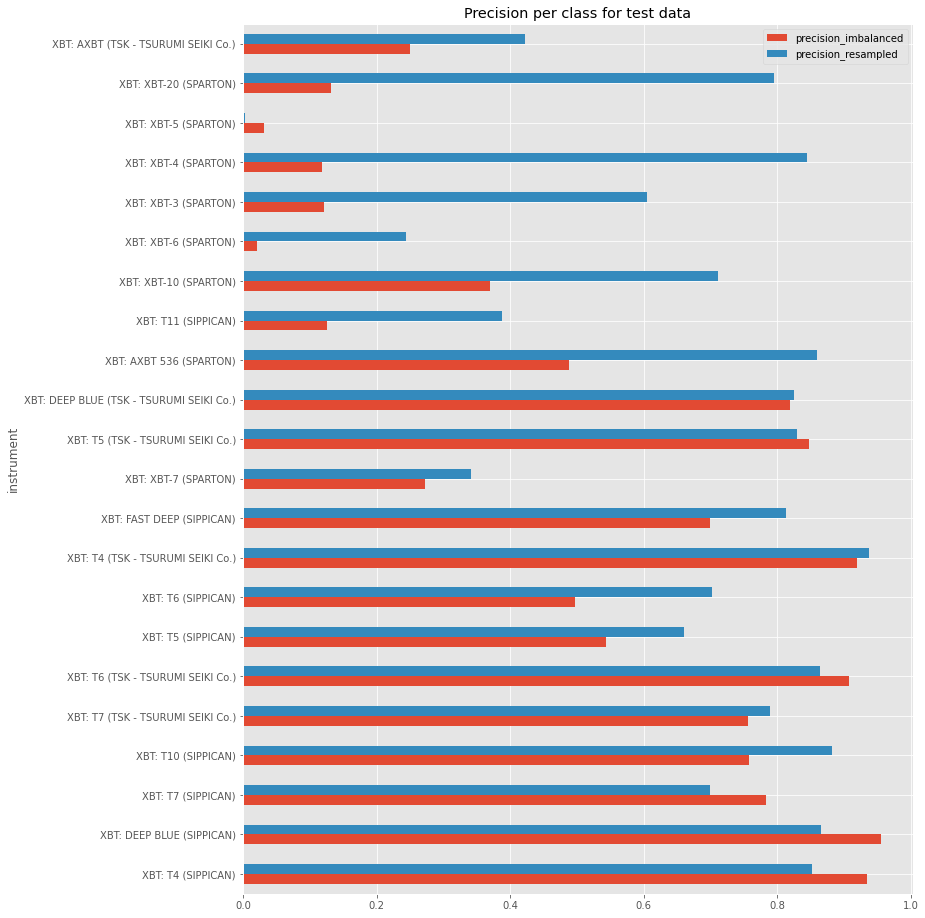

In [77]:
fig1 = matplotlib.pyplot.figure('precision_per_class_test', figsize=(12,16))
ax1 = fig1.add_subplot(1,1,1,title='Precision per class for test data')
_ = pandas.DataFrame({'instrument': metrics_per_class_cv_df_plot['instrument'], 
                  'precision_imbalanced': metrics_per_class_cv_df_plot['precision_instr_avg'],
                  'precision_resampled': metrics_per_class_resampled_df_plot['precision_instr_avg'],
                 }).plot.barh(x='instrument', ax=ax1)
fig1.savefig('/data/users/shaddad/xbt-data/plots/precision_test_per_class_imbalancedClf.png', bbox_inches='tight')

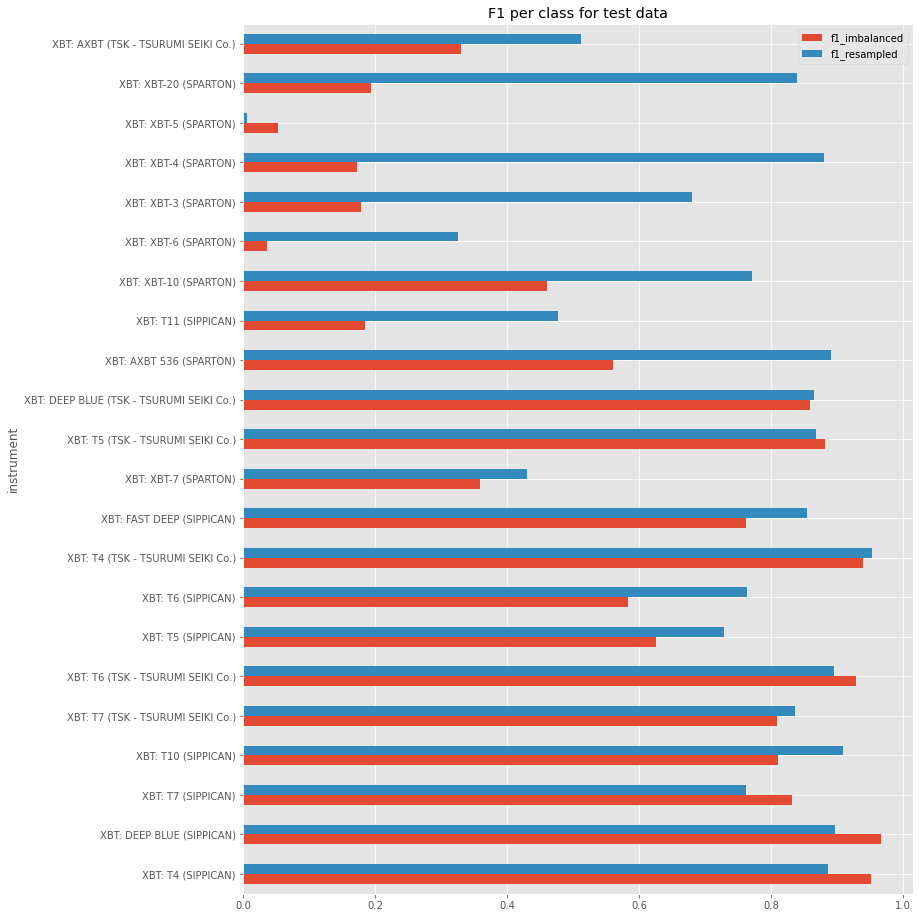

In [78]:
fig1 = matplotlib.pyplot.figure('f1_per_class_test', figsize=(12,16))
ax1 = fig1.add_subplot(1,1,1,title='F1 per class for test data')
_ = pandas.DataFrame({'instrument': metrics_per_class_cv_df_plot['instrument'], 
                  'f1_imbalanced': metrics_per_class_cv_df_plot['f1_instr_avg'],
                  'f1_resampled': metrics_per_class_resampled_df_plot['f1_instr_avg'],
                 }).plot.barh(x='instrument', ax=ax1)
fig1.savefig('/data/users/shaddad/xbt-data/plots/f1_test_per_class_imbalancedClf.png', bbox_inches='tight')

In [79]:
instr_encoder = xbt_labelled._feature_encoders['instrument']

In [80]:
%%time
imeta_results = []
for year in range(env_date_ranges[environment][0],env_date_ranges[environment][1]):
    y_imeta_instr = instr_encoder.transform(pandas.DataFrame(imeta_instrument[xbt_labelled.xbt_df.year == year]))
    xbt_instr1 = instr_encoder.transform(pandas.DataFrame(xbt_labelled.xbt_df[xbt_labelled.xbt_df.year == year].instrument))
    (im_pr_instr, im_rec_instr, im_f1_instr, im_sup_instr) = sklearn.metrics.precision_recall_fscore_support(xbt_instr1, y_imeta_instr,average='weighted')
    im_acc_instr = sklearn.metrics.accuracy_score(xbt_instr1, y_imeta_instr)
    imeta_results += [{'year': year,
                       'imeta_instr_recall': im_rec_instr,
                       'imeta_instr_precision': im_pr_instr,
                       'imeta_instr_f1': im_f1_instr,
                       'imeta_instr_accuracy': im_acc_instr,
                      }]

CPU times: user 1.24 s, sys: 0 ns, total: 1.24 s
Wall time: 1.24 s


In [81]:
imeta_results_df = pandas.DataFrame.from_records(imeta_results)

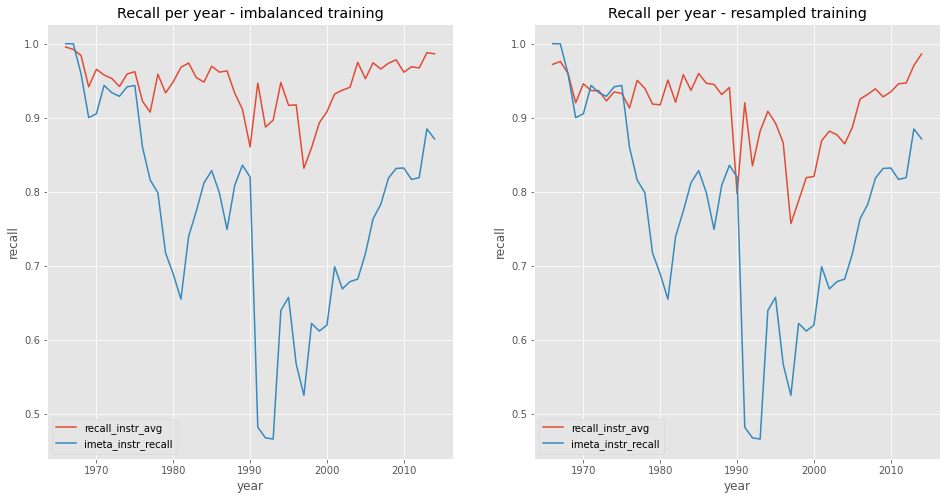

In [82]:
fig1 = matplotlib.pyplot.figure('recall_perYear', figsize=(16,8))
ax1 = fig1.add_subplot(1,2,1, title='Recall per year - imbalanced training')
metrics_annual_cv_df.plot.line(x='year', y='recall_instr_avg', ax=ax1)
imeta_results_df.plot.line(x='year', y='imeta_instr_recall', ax=ax1)
ax1.set_ylabel('recall')
ax1 = fig1.add_subplot(1,2,2, title='Recall per year - resampled training')
metrics_annual_resampled_df.plot.line(x='year', y='recall_instr_avg', ax=ax1)
imeta_results_df.plot.line(x='year', y='imeta_instr_recall', ax=ax1)
ax1.set_ylabel('recall')
fig1.savefig('/data/users/shaddad/xbt-data/plots/recall_perYear_imbalancedVsResampled.png', bbox_inches='tight')

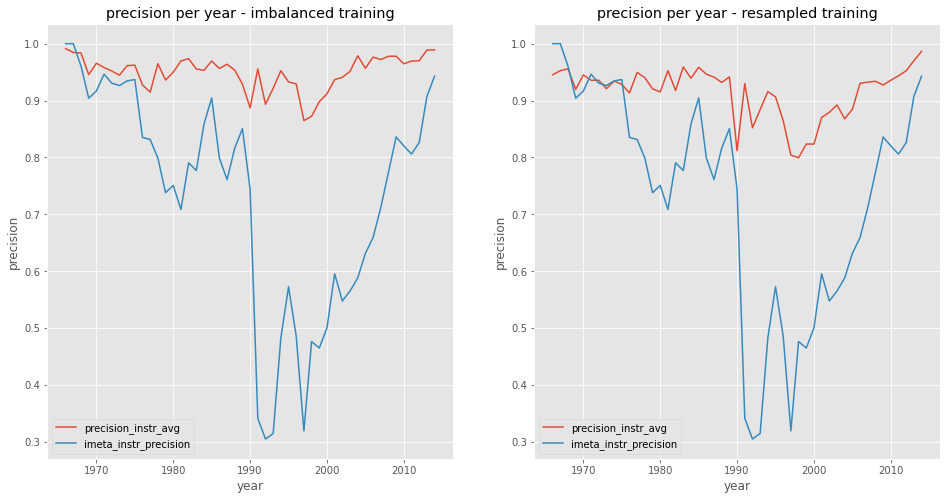

In [83]:
fig1 = matplotlib.pyplot.figure('precision_perYear', figsize=(16,8))
ax1 = fig1.add_subplot(1,2,1, title='precision per year - imbalanced training')
metrics_annual_cv_df.plot.line(x='year', y='precision_instr_avg', ax=ax1)
imeta_results_df.plot.line(x='year', y='imeta_instr_precision', ax=ax1)
ax1.set_ylabel('precision')
ax1 = fig1.add_subplot(1,2,2, title='precision per year - resampled training')
metrics_annual_resampled_df.plot.line(x='year', y='precision_instr_avg', ax=ax1)
imeta_results_df.plot.line(x='year', y='imeta_instr_precision', ax=ax1)
ax1.set_ylabel('precision')
fig1.savefig('/data/users/shaddad/xbt-data/plots/precision_perYear_imbalancedVsResampled.png', bbox_inches='tight')

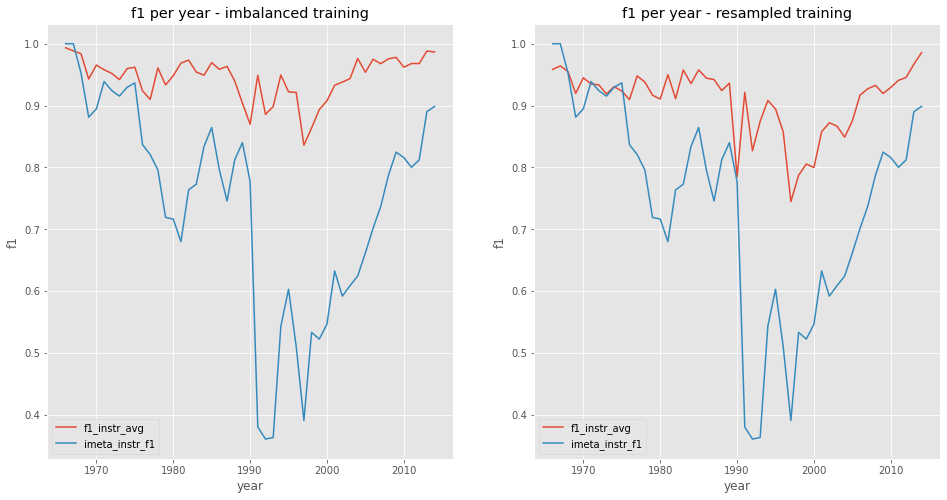

In [84]:
fig1 = matplotlib.pyplot.figure('f1_imbalance_resample_perYear', figsize=(16,8))
ax1 = fig1.add_subplot(1,2,1, title='f1 per year - imbalanced training')
metrics_annual_cv_df.plot.line(x='year', y='f1_instr_avg', ax=ax1)
imeta_results_df.plot.line(x='year', y='imeta_instr_f1', ax=ax1)
ax1.set_ylabel('f1')
ax1 = fig1.add_subplot(1,2,2, title='f1 per year - resampled training')
metrics_annual_resampled_df.plot.line(x='year', y='f1_instr_avg', ax=ax1)
imeta_results_df.plot.line(x='year', y='imeta_instr_f1', ax=ax1)
ax1.set_ylabel('f1')
fig1.savefig('/data/users/shaddad/xbt-data/plots/f1_perYear_imbalancedVsResampled.png', bbox_inches='tight')

## Comparing ensemble apporaches

In [85]:
vote_counts_super_df = pandas.DataFrame.from_records( 
    {year1: dict(xbt_test.filter_obs({'year': year1}).filter_features(ens_res_features_cv + ens_res_features).xbt_df.apply(calc_disagreements, axis='columns').value_counts()) for year1 in range(*year_range)},
).transpose().fillna(0.0)
vote_counts_super_df['year'] = vote_counts_super_df.index

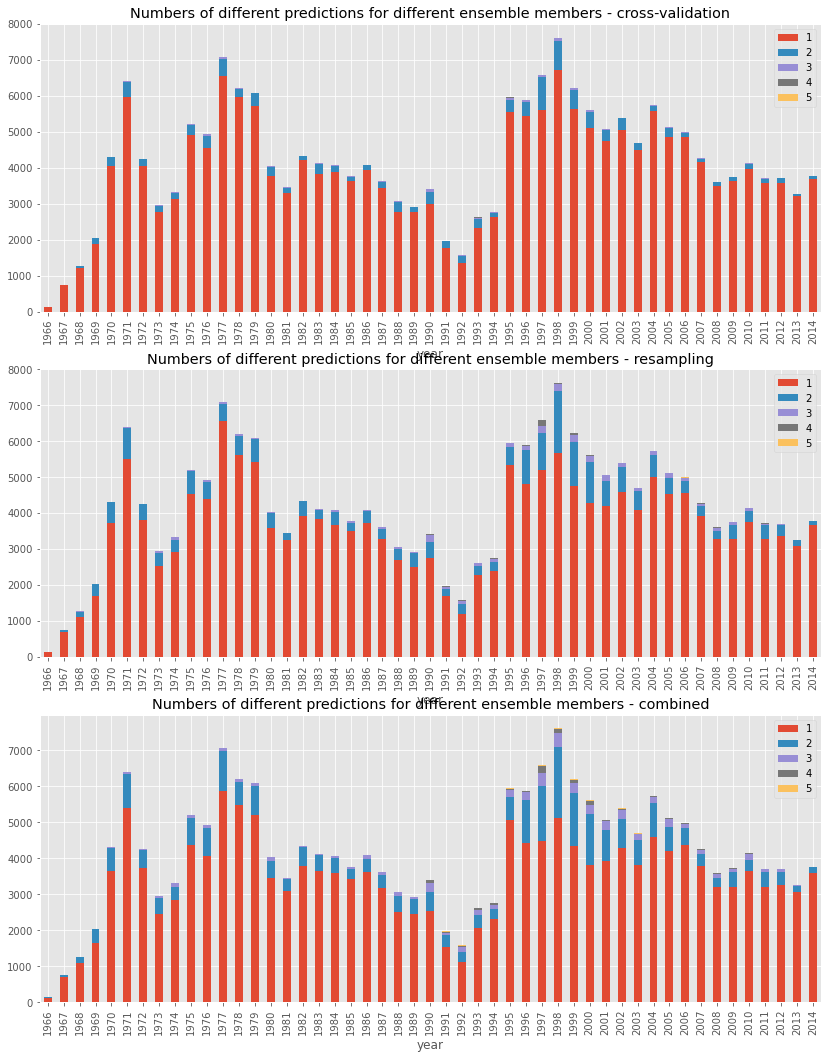

In [86]:
fig1 = matplotlib.pyplot.figure('vote_counts_year', figsize=(14,18))
ax1 = fig1.add_subplot(3,1,1,title='Numbers of different predictions for different ensemble members - cross-validation')
vote_counts_cv_df.plot.bar(
    x='year',
    y=[1,2,3,4,5],
    stacked=True,
    ax=ax1,
)
ax1 = fig1.add_subplot(3,1,2,title='Numbers of different predictions for different ensemble members - resampling')
vote_counts_df.plot.bar(
    x='year',
    y=[1,2,3,4,5],
    stacked=True,
    ax=ax1,
)
ax1 = fig1.add_subplot(3,1,3,title='Numbers of different predictions for different ensemble members - combined')
vote_counts_super_df.plot.bar(
    x='year',
    y=[1,2,3,4,5],
    stacked=True,
    ax=ax1,
)

fig1.savefig('/data/users/shaddad/xbt-data/plots/ensemble_resample_vote_counts.png',
            bbox_inches='tight')

In [87]:
probs_test_instrument_super = functools.reduce(lambda x,y: x+y, [xbt_labelled._target_encoders[target_feature_name].transform(xbt_test.xbt_df[[pred1]])
for pred1 in xbt_test.xbt_df.columns if 'res' in pred1]) / len([pred1 for pred1 in xbt_test.xbt_df.columns if 'res' in pred1])
probs_test_instrument_super_df = pandas.DataFrame({col_name: probs_test_instrument_super[:,col_ix1]
for col_ix1, col_name in enumerate(xbt_labelled._target_encoders[target_feature_name].categories_[0])})
max_prob_super_ensemble = probs_test_instrument_super_df.idxmax(axis='columns')

In [88]:
metrics_ens_cv_max_prob_all = { f'{metric_name}_instr_ens' :
    metric1['metric_func'](
        xbt_test._feature_encoders[target_feature_name].transform(max_prob_cv_ensemble),
        xbt_test.filter_features([target_feature_name]).get_ml_dataset()[0],
        **metric1['metric_args_dict']
    )
    for metric_name,metric1 in metrics_defs_dict.items()    
}
metrics_ens_cv_max_prob_all['classifier'] = 'cv_ensemble'

In [89]:
metrics_ens_resampled_max_prob_all = { f'{metric_name}_instr_ens' :
    metric1['metric_func'](
        xbt_test._feature_encoders[target_feature_name].transform(max_prob_resample_ensemble),
        xbt_test.filter_features([target_feature_name]).get_ml_dataset()[0],
        **metric1['metric_args_dict']
    )
    for metric_name,metric1 in metrics_defs_dict.items()    
}
metrics_ens_resampled_max_prob_all['classifier'] = 'resampled_ensemble'

In [90]:
metrics_ens_super_max_prob_all = { f'{metric_name}_instr_ens' :
    metric1['metric_func'](
        xbt_test._feature_encoders[target_feature_name].transform(max_prob_super_ensemble),
        xbt_test.filter_features([target_feature_name]).get_ml_dataset()[0],
        **metric1['metric_args_dict']
    )
    for metric_name,metric1 in metrics_defs_dict.items()    
}
metrics_ens_super_max_prob_all['classifier'] = 'super_ensemble'

In [91]:
metrics_max_prob = pandas.DataFrame.from_records([metrics_ens_cv_max_prob_all, 
                              metrics_ens_resampled_max_prob_all,
                              metrics_ens_super_max_prob_all,
                             ])
pandas.concat([
    metrics_all_classifiers[metrics_all_classifiers['classifier'] == 'imeta'],
    metrics_max_prob,
])

,recall_instr_ens,precision_instr_ens,accuracy_instr_ens,f1_instr_ens,balanced_accuracy_instr_ens,classifier
0,0.759407,0.794530,0.759407,0.763800,0.594709,imeta
0,0.944576,0.947151,0.944576,0.945349,0.779624,cv_ensemble
1,0.916080,0.914482,0.916080,0.911677,0.579194,resampled_ensemble
2,0.943954,0.945123,0.943954,0.943897,0.695092,super_ensemble


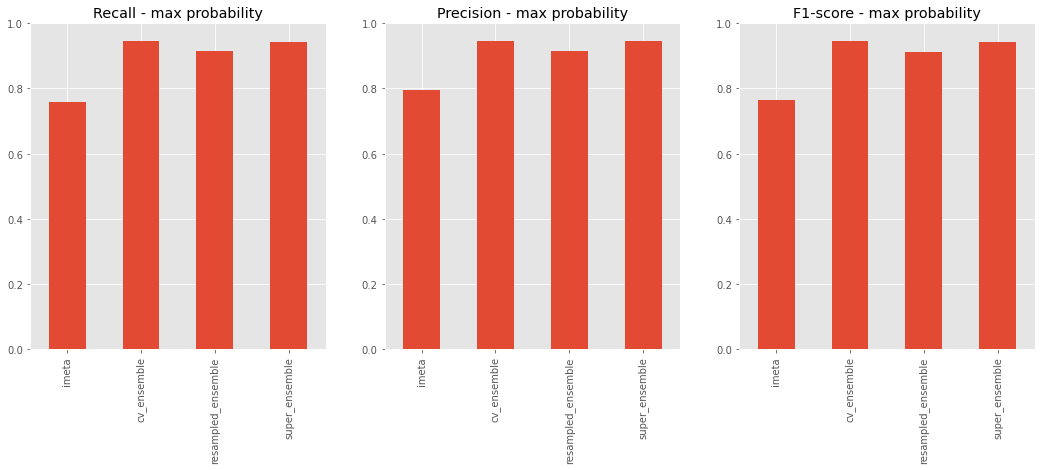

In [92]:
fig_metrics_max_prob = matplotlib.pyplot.figure('max_prob_metrics', figsize=(18,6))
ax_max_prob_recall = fig_metrics_max_prob.add_subplot(1,3,1, title='Recall - max probability')
pandas.concat([
    metrics_all_classifiers[metrics_all_classifiers['classifier'] == 'imeta'],
    metrics_max_prob,
]).plot.bar(x='classifier', y='recall_instr_ens', ylim=(0.0,1.0), ax=ax_max_prob_recall, legend=False)
ax_max_prob_recall.set_xlabel('')
ax_max_prob_precision = fig_metrics_max_prob.add_subplot(1,3,2, title='Precision - max probability')
pandas.concat([
    metrics_all_classifiers[metrics_all_classifiers['classifier'] == 'imeta'],
    metrics_max_prob,
]).plot.bar(x='classifier', y='precision_instr_ens', ylim=(0.0,1.0), ax=ax_max_prob_precision, legend=False)
ax_max_prob_precision.set_xlabel('')
ax_max_prob_f1 = fig_metrics_max_prob.add_subplot(1,3,3, title='F1-score - max probability')
pandas.concat([
    metrics_all_classifiers[metrics_all_classifiers['classifier'] == 'imeta'],
    metrics_max_prob,
]).plot.bar(x='classifier', y='f1_instr_ens', ylim=(0.0,1.0), ax=ax_max_prob_f1, legend=False)
_ = ax_max_prob_f1.set_xlabel('')
fig_metrics_max_prob.savefig('/data/users/shaddad/xbt-data/plots/metrics_max_prob_ensembles.png',
            bbox_inches='tight')

<AxesSubplot:xlabel='classifier'>

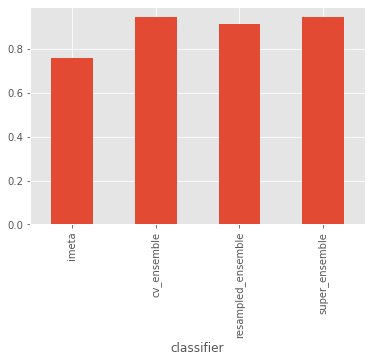

In [93]:
pandas.concat([
    metrics_all_classifiers[metrics_all_classifiers['classifier'] == 'imeta'],
    metrics_max_prob,
]).plot.bar(x='classifier', y='recall_instr_ens', legend=False)


In [94]:
metrics_all_classifiers

,recall_instr_ens,precision_instr_ens,accuracy_instr_ens,f1_instr_ens,balanced_accuracy_instr_ens,classifier
0,0.906018,0.903344,0.906018,0.900307,0.572243,resampled_1
1,0.903450,0.901197,0.903450,0.897879,0.576062,resampled_2
2,0.905175,0.902849,0.905175,0.900030,0.567952,resampled_3
3,0.907526,0.905806,0.907526,0.902091,0.557007,resampled_4
4,0.907049,0.904820,0.907049,0.901858,0.564130,resampled_5
0,0.939675,0.942081,0.939675,0.940359,0.748968,cv_0
1,0.939636,0.941530,0.939636,0.940216,0.727702,cv_1
2,0.938706,0.940931,0.938706,0.939278,0.712468,cv_2
3,0.940426,0.942657,0.940426,0.941106,0.718732,cv_3
4,0.939622,0.941989,0.939622,0.940364,0.737669,cv_4


In [95]:
pandas.DataFrame({
    'max_prob_cv':max_prob_cv_ensemble.value_counts(),
    'max_prob_resampled': max_prob_resample_ensemble.value_counts(),
    'max_prob_super': max_prob_super_ensemble.value_counts(),
})

,max_prob_cv,max_prob_resampled,max_prob_super
XBT: AXBT (TSK - TSURUMI SEIKI Co.),13,31.0,31
XBT: AXBT 536 (SPARTON),150,199.0,174
XBT: DEEP BLUE (SIPPICAN),65086,62177.0,64988
XBT: DEEP BLUE (TSK - TSURUMI SEIKI Co.),209,278.0,231
XBT: FAST DEEP (SIPPICAN),871,1158.0,905
XBT: T10 (SIPPICAN),9090,10899.0,10219
XBT: T10 (TSK - TSURUMI SEIKI Co.),5,NaN,2
XBT: T11 (SIPPICAN),75,362.0,187
XBT: T4 (SIPPICAN),81457,77579.0,80272
XBT: T4 (TSK - TSURUMI SEIKI Co.),1336,1424.0,1363
